# 3.Convolutional Neural Networks

## 3.1Convolutional Neural Networks: Step by Step

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# matpplotlib inline
plt.rcParams['figure.figsize'] = (5.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [8]:
def zero_pad(X, pad):
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant',constant_values = 0)
    
    return X_pad

In [9]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


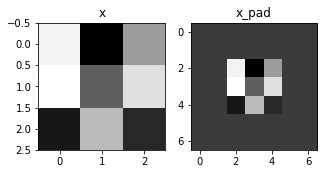

In [10]:
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [11]:
def conv_single_step(a_slice_prev, W, b):
    s = a_slice_prev * W + b
    # Sum over all entries of the volume s
    Z = np.sum(s)
    ### END CODE HERE ###
    return Z

In [12]:
def conv_forward(A_prev,W,b,hparameters):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f,f,n_C_prev,n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int((n_H_prev - f + 2 * pad)/stride) + 1
    n_W = int((n_W_prev - f + 2 * pad)/stride) + 1
    
    Z = np.zeros((m,n_H,n_W,n_C))
    
    A_pre_pad = zero_pad(A_prev,pad)
    
    for i in range(m):
        a_prev_pad = A_pre_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    Z[i,h,w,c] = np.sum(np.multiply(a_slice_prev,W[:,:,:,c])+b[:,:,:,c])
                    
    assert(Z.shape == (m,n_H,n_W,n_C))
    cache = (A_prev,W,b,hparameters)
    
    return Z,cache

In [13]:
def pool_forward(A_prev, hparameters, mode = "max"):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev[i, vert_start:vert_end,horiz_start:horiz_end, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
                        
    cache = (A_prev, hparameters)
    assert(A.shape == (m, n_H, n_W, n_C))
    return A, cache

In [14]:
def conv_backward(dZ,cache):
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    (m, n_H, n_W, n_C) = dZ.shape
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros(b.shape)
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end, : ]
                    
                    da_prev_pad[vert_start:vert_end,horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i,h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    return dA_prev, dW, db

In [15]:
def create_mask_from_window(x):
    mask = (x == np.max(x))
    ### END CODE HERE ###
    return mask

In [16]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


In [17]:
def distribute_value(dz, shape):
    (n_H, n_W) = shape
    # Compute the value to distribute on the matrix (￿1 line)
    average = dz / (n_H * n_W)
    a = np.ones(shape) * average
    ### END CODE HERE ###
    return a

In [18]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


In [19]:
def pool_backward(dA, cache, mode = "max"):
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start: vert_end,horiz_start: horiz_end, c] += mask *dA[i, vert_start, horiz_start, c]
                    elif mode == "average":
                        da = dA[i, vert_start, horiz_start, c]
                        shape = (f, f)
                        dA_prev[i, vert_start: vert_end,horiz_start: horiz_end, c] += distribute_value(da, shape)
                        
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev